## Import

In [2]:
import os 
import sys 
import numpy as np 
import pandas as pd
import scipy 
import inspect 
import pickle 

In [3]:
from pyMSOO.MFEA.model import MFEA_base, SM_MFEA, LSA21
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 

from pyMSOO.utils.EA import * 
from pyMSOO.MFEA.benchmark.continous.CEC17 import CEC17_benchmark 
from pyMSOO.MFEA.benchmark.continous.WCCI22 import WCCI22_benchmark
from pyMSOO.MFEA.benchmark.continous.utils import Individual_func 
from pyMSOO.MFEA.benchmark.continous.funcs import * 

from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

## Utils

In [5]:
def classname_to_class(classname):
    return getattr(sys.modules[__name__], classname)

def module_class_str_to_class(module, classname):
    # print(module, classname)
    if module == 'SMP_MFEA': 
        module= 'SM_MFEA'
    return getattr(sys.modules[__name__].__dict__[module], classname)

## LoadModel 

In [4]:
primary_type= [int,np.int32,np.uint8, float, np.float32, np.float64, np.ndarray,tuple, bool, str, list] 

In [6]:
with open("./new_model.mso", 'rb') as file: 
    model_dict = pickle.load(file)

In [55]:

import inspect 

ls_error = [] 


def restore_list_attr(ls):
    global primary_type 
    # primary_type= [int, np.uint8, float, np.float32, np.float64, np.ndarray,tuple, bool, str, type(None), list]
    new_ls = [] 
    for element in ls:
        if type(element) in primary_type: 
            if type(element) is list:
                new_ls.append(restore_list_attr(element))
            else: new_ls.append(element) 
        else: 
            if type(element) is dict: 
                if element['name_type_object'].lower() == 'dict': 
                    new_ls.append(restore_dict_attr(element))
                else:
                    new_ls.append(restore_object(element))
    return new_ls

def restore_dict_attr(diction: dict): 
    new_dict = {}
    global primary_type
    # primary_type= [int, np.uint8, float, np.float32, np.float64, np.ndarray,tuple, bool, str, type(None), list]
    for key, value in diction.items():
        if type(value) is list:
            new_dict[key]= restore_list_attr(value) 
            pass 
        elif type(value) is dict: 
            if value['name_type_object'].lower() == 'dict': 
                new_dict[key] = restore_dict_attr(value)
            else: 
                new_dict[key] = restore_object(value) 
        elif type(value) in primary_type: 
            new_dict[key] = value 
        else: 
            error = f"{key}: {value} cannot assigned"
            if error not in ls_error:
                print(error)
                ls_error.append(error)
    


def assign_attribute(model, attri_diction: dict):
    global primary_type
    for key, value in attri_diction.items():
        if type(value) is list: 
            # model.key = process_list_attr(value)
            setattr(model, key, restore_list_attr(value))
        elif type(value) is dict: 
            if value['name_type_object'].lower() == 'dict': 
                setattr(model, key, restore_dict_attr(value))
            else:
                setattr(model, key, restore_object(value))
        elif type(value) in primary_type: 
            setattr(model, key, (value))
            # model.key = value 
        else: 
            error = f"{key}: {value} ||| {type(value)} cannot assigned"
            if error not in ls_error:
                print(error)
                ls_error.append(error)
        
    return model 


def restore_object(diction):
    if type(diction) is not dict: 
        return None 
    if diction['name_type_object'].lower() == 'dict':
        return restore_dict_attr(diction)
    # print(diction)
    if diction['name_type_object'] == 'function':
        return None 
    try:
        if len(diction['name_type_object'].split(".")) == 1: 
            if '__module__' not in diction.keys():
                model = classname_to_class(diction['name_type_object'])
            else: 
                try: 
                    model = classname_to_class(diction['name_type_object'])
                except:
                    try:
                        model = module_class_str_to_class(diction['__module__'].split(".")[-1], diction['name_type_object'])
                    except:
                        error = (f"Cannot restore {diction['name_type_object']}")
                        if error not in ls_error:
                            print(error)
                            ls_error.append(error)
                        return None 
        else: 
            module, classname = diction['name_type_object'].split(".")[-2:]

            model = module_class_str_to_class(module, classname) 
    except :
        class Temp: 
            def __init__(self) -> None:
                pass
        model = Temp 
        error = f"Error when create object {diction['name_type_object']}. Using Temp class instead"
        if error not in ls_error:
            print(error)
            ls_error.append(error)

        
    if '__module__' in diction.keys():
        return model 

    # return model 
    init_parameters = {} 
    signature = inspect.signature(model.__init__).parameters 
    for name, parameter in signature.items(): 
        if name == 'self': continue 
        if name in diction.keys(): 
            # print(name)
            if type(diction[name]) is dict: 
                if diction[name]['name_type_object'].lower() == 'dict':
                    init_parameters[name] = restore_dict_attr(diction[name])
                else: 
                    init_parameters[name] = restore_object(diction[name])
            elif type(diction[name]) is list: 
                init_parameters[name] = restore_list_attr(diction[name])
            elif type(diction[name]) in primary_type:
                init_parameters[name] = diction[name] 
            else: 
                error = (f'Cannot convert {diction[name]} to create init parameters')
                if error not in ls_error:
                    print(error)
                    ls_error.append(error)
                
                init_parameters[name]= None 
            # print(init_parameters[name])
            # print()
        else: 
            # print(parameter.default)
            init_parameters[name] = parameter.default
    try:
        instance_model = model(**init_parameters)
    except :
        # if e not in ls_error:
        #     print(e) 
        #     ls_error.append(e)
        # print()
        error = (f"Error while create instance model for {model}. Using Temp class instead")
        if error not in ls_error:
            print(error)
            ls_error.append(error)
        class Temp: 
            def __init__(self) -> None:
                pass 
        instance_model = Temp() 

    new_model = assign_attribute(instance_model, diction)
    return new_model 


In [56]:
restore_model = restore_object(model_dict)

Error when create object DictType. Using Temp class instead
Error when create object UnicodeType. Using Temp class instead
Error when create object Float. Using Temp class instead
Error while create instance model for typing.Tuple. Using Temp class instead
Error when create object UnionType. Using Temp class instead
Error when create object L_SHADE. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.Population'>. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.SubPopulation'>. Using Temp class instead


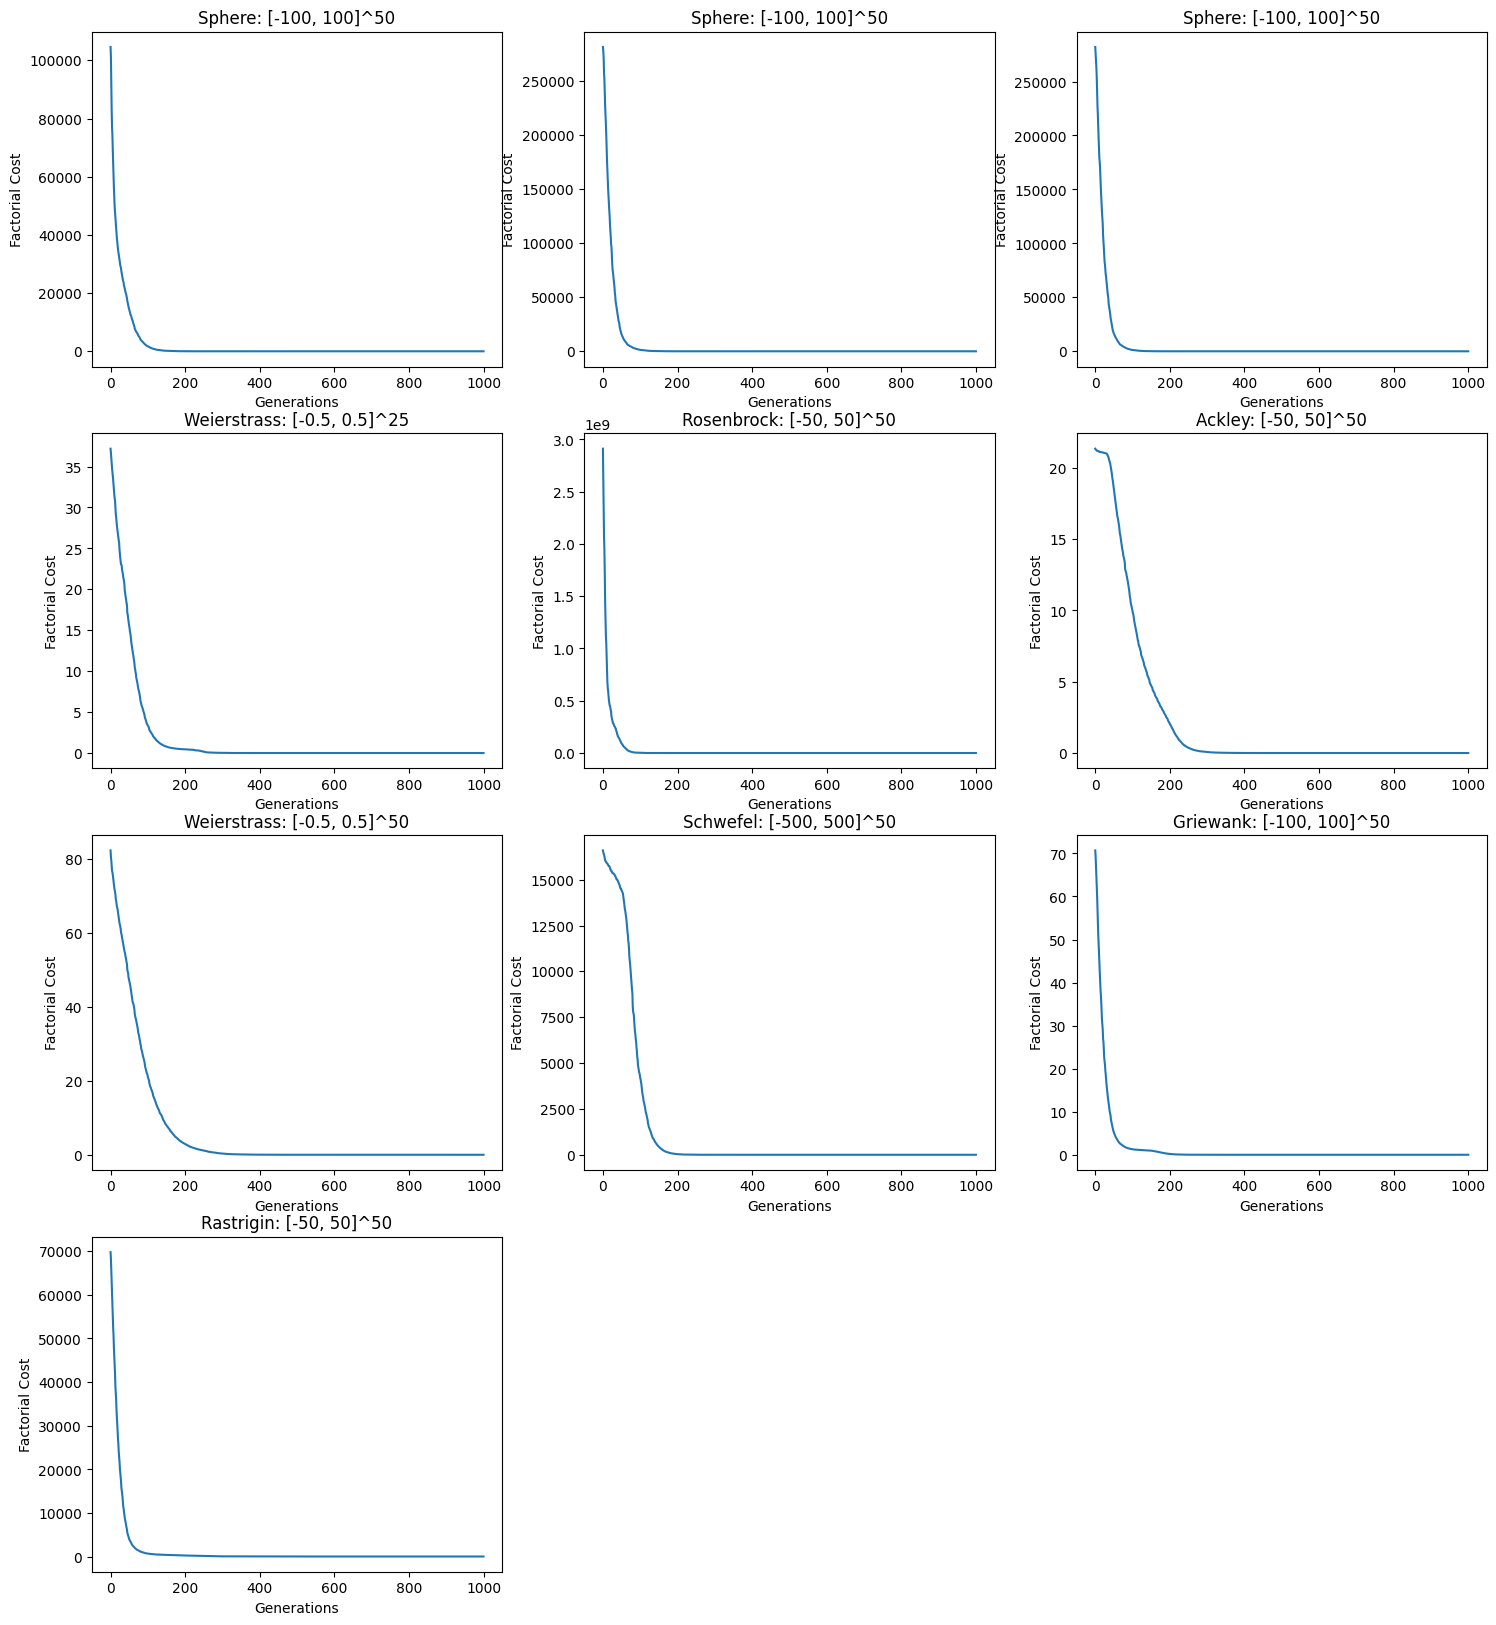

In [46]:
restore_model.render_history()

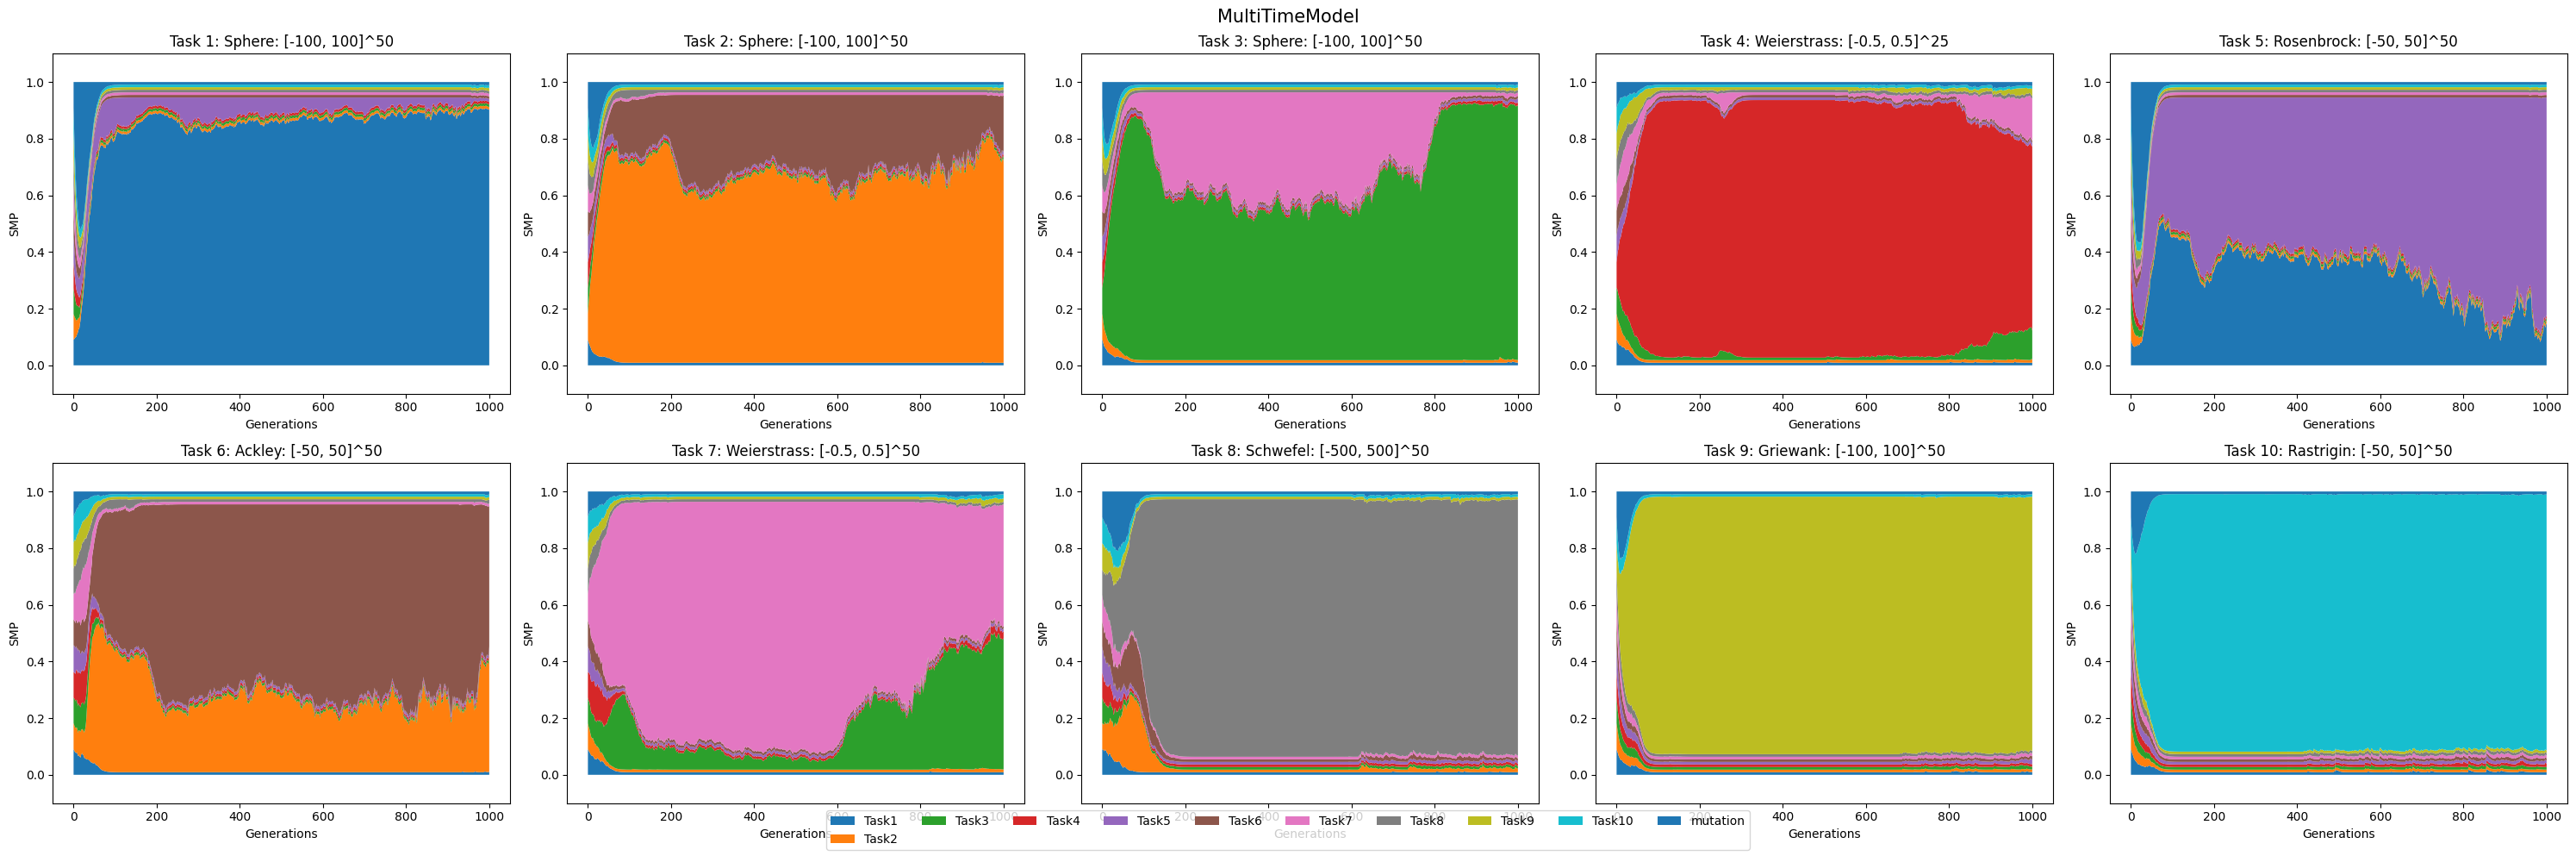

In [45]:
restore_model.render_smp(shape=(2,5))

In [7]:
restore_model.render_smp(shape=(2,5), title= "", grid= False, label_loc= "lower center",
    title_size= 20,
    label_size_x= 20,
    label_size_y= 20,
    x_tick_size= 20,
    y_tick_size= 20,
    handletextpad= 1,
    # borderaxespad=0.8,
    bbox_to_anchor=(0.5,-0.06),
    legend_size= 21,
    ncol = 11, 
)

AttributeError: 'MultiTimeModel' object has no attribute 'render_smp'

# Run test

In [4]:
from pyMSOO.MFEA.model import MFEA_base, SM_MFEA 
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 

tasks, IndClass = CEC17_benchmark.get_10tasks_benchmark()

baseModel = MFEA_base.model()
baseModel.compile(
    IndClass= IndClass,
    tasks= tasks,
    # crossover = KL_SBXCrossover(nc= 2, k= 100, conf_thres= 1),
    crossover= SBX_Crossover(nc = 2),
    mutation= PolynomialMutation(nm = 5),
    selection= ElitismSelection()
)
solve = baseModel.fit(
    nb_generations = 1000, rmp = 0.3, nb_inds_each_task= 100, 
    bound_pop= [0, 1], evaluate_initial_skillFactor= True
)

Seed: None -- Time: 01m 8.85s  100 % [====================>]  Cost: 1.29E-01  8.09E-02  3.28E-01  1.83E-01  1.15E+01  6.85E-02  9.06E-01  3.52E+03  2.32E-02  3.23E+01  ,  
END!


In [7]:
from pyMSOO.MFEA.model import MFEA_base, SM_MFEA 
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

# cec17
t, ic = CEC17_benchmark.get_10tasks_benchmark()

ls_benchmark = [t]
ls_IndClass = [ic]
name_benchmark = ["cec17"]

smpModel = MultiBenchmark(
    ls_benchmark= ls_benchmark,
    name_benchmark= name_benchmark,
    ls_IndClass= ls_IndClass,
    model= SM_MFEA
)
smpModel.compile( 
    # crossover = KL_SBXCrossover(nc= 2, u= 0.001, conf_thres= 1),
    crossover = SBX_Crossover(nc = 2),
    mutation = PolynomialMutation(nm = 5, pm= 1),
    selection= ElitismSelection(random_percent= 0.1),
    search= L_SHADE(len_mem= 15),
    attr_tasks = ['crossover', 'mutation', 'search'],
)
smpModel.fit(
    nb_generations= 10, nb_inds_each_task= 100, nb_inds_min= 20,
    lr = 0.1, p_const_intra= 0., prob_search = 0., lc_nums = 200,
    nb_epochs_stop= 1000, swap_po= False,
    evaluate_initial_skillFactor= True
)
a = smpModel.run(
    nb_run= 5,     
    save_path= './RESULTS/'
)
print()

Seed: 0 -- Time: 00m 1.52s  100 % [====================>]  Pop_size: 1.10E+02  ,  Cost: 4.07E+04  9.25E+04  1.27E+05  2.74E+01  3.92E+08  2.11E+01  6.00E+01  1.64E+04  2.63E+01  3.36E+04  ,  
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1006, 1054, 1062, 1000, 930, 1024, 1032, 928, 1036, 998]
END!
Seed: 1 -- Time: 00m 1.07s  100 % [====================>]  Pop_size: 1.10E+02  ,  Cost: 4.35E+04  1.12E+05  1.17E+05  2.56E+01  6.94E+08  2.11E+01  6.79E+01  1.59E+04  3.32E+01  2.71E+04  ,  
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[976, 1044, 1000, 994, 974, 1018, 1010, 944, 1090, 1020]
END!
Seed: 2 -- Time: 00m 1.10s  100 % [====================>]  Pop_size: 1.10E+02  ,  Cost: 3.71E+04  1.44E+05  9.34E+04  2.47E+01  4.45E+08  2.10E+01  6.23E+01  1.64E+04  2.51E+01  1.45E+04  ,  
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1032, 918, 980, 1006, 948, 1028, 1064, 980, 988, 1126]
END!
Seed: 3 -- Time: 00m 1.04s  100 % [====================>]  Pop_size: 1.10E+02  ,  Cost: 3.78E+04  1.16E+05  9.24

In [8]:
from pyMSOO.utils.LoadSaveModel.LoadModel import restore_object, loadModel

# with open("./new_model.mso", 'rb') as file: 
#     model_dict = pickle.load(file)

# model = restore_object(model_dict)

model = loadModel("./RESULTS/cec17.mso")

In [4]:
model

## Run LSA21

In [5]:
t, ic = CEC17_benchmark.get_10tasks_benchmark()

ls_benchmark = [t]
ls_IndClass = [ic]
name_benchmark = ["cec17"]



smpModel = MultiBenchmark(
    ls_benchmark= ls_benchmark,
    name_benchmark= name_benchmark,
    ls_IndClass= ls_IndClass,
    model= LSA21
)

smpModel.compile(

    # crossover= SBX_LSA21(nc=2, k=7),
    crossover = DaS_SBX_Crossover(nc=2, eta=3),
    selection= ElitismSelection(random_percent= 0.),
    mutation= NoMutation(),
    search = LSHADE_LSA21(len_mem=30, p_ontop=0.11),
    attr_tasks = ['crossover', 'mutation', 'search'],
)
smpModel.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 4,
    lr = 0.1, step = 5000,
)
a = smpModel.run(
    nb_run= 1,
    save_path= './RESULTS/Many/SMP_v2/'
)

Seed: 0 -- Time: 08m 24.58s  100 % [====================>]  Pop_size: 4.00E+01  ,  Cost: 1.62E-27  2.58E-26  1.41E-27  0.00E+00  5.83E-09  5.02E-14  0.00E+00  6.36E-04  0.00E+00  0.00E+00  ,  
[ 95148.  96052. 102456. 105922.  95070.  97184. 107763.  95838. 102637.
 101963.]
END!
DONE!
None


In [6]:
from pyMSOO.utils.LoadSaveModel.LoadModel import restore_object 

with open("./new_model.mso", 'rb') as file: 
    model_dict = pickle.load(file)

model = restore_object(model_dict)

Error when create object DictType. Using Temp class instead
Error when create object UnicodeType. Using Temp class instead
Error when create object Float. Using Temp class instead
Error when create object Tuple. Using Temp class instead
Error when create object UnionType. Using Temp class instead
Error when create object rmp_lsa21. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.Population'>. Using Temp class instead
Error while create instance model for <class 'pyMSOO.utils.EA.SubPopulation'>. Using Temp class instead


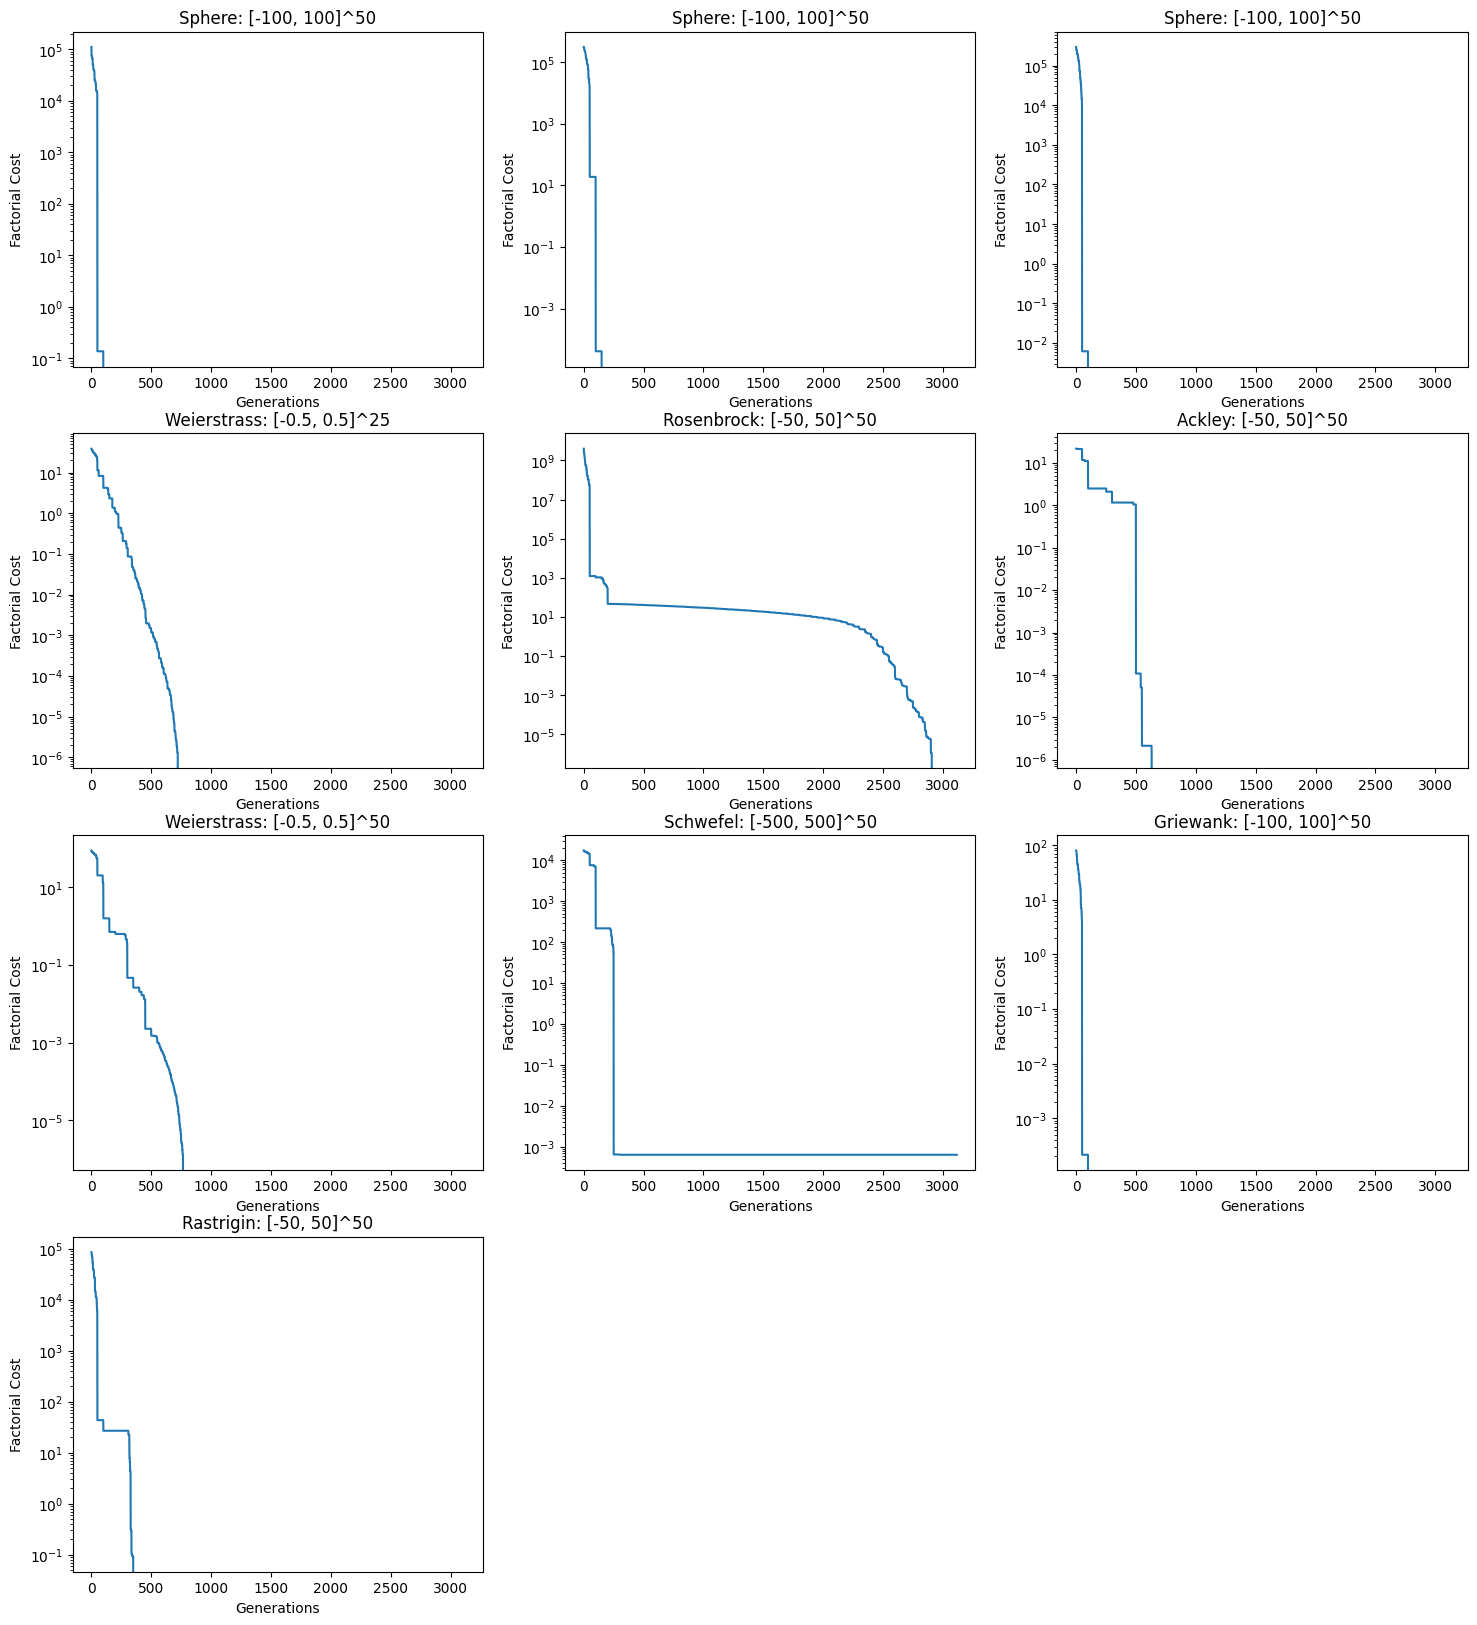

In [9]:
model.render_history(yscale='log')

# Optimize time

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys 
import numpy as np 
import pandas as pd
import scipy 
import inspect 
import pickle 

from pyMSOO.MFEA.model import MFEA_base, SM_MFEA, LSA21
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 

from pyMSOO.utils.EA import * 
from pyMSOO.MFEA.benchmark.continous.CEC17 import CEC17_benchmark 
from pyMSOO.MFEA.benchmark.continous.WCCI22 import WCCI22_benchmark
from pyMSOO.MFEA.benchmark.continous.utils import Individual_func 
from pyMSOO.MFEA.benchmark.continous.funcs import * 

from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

from pyMSOO.utils.numba_utils import *

In [2]:
t, ic = CEC17_benchmark.get_10tasks_benchmark()

ls_benchmark = [t]
ls_IndClass = [ic]
name_benchmark = ["cec17"]



smpModel = MultiBenchmark(
    ls_benchmark= ls_benchmark,
    name_benchmark= name_benchmark,
    ls_IndClass= ls_IndClass,
    model= LSA21
)

smpModel.compile(

    # crossover= SBX_LSA21(nc=2, k=7),
    crossover = DaS_SBX_Crossover(nc=2, eta=3),
    selection= ElitismSelection(random_percent= 0.),
    mutation= NoMutation(),
    search = LSHADE_LSA21(len_mem=30, p_ontop=0.11),
    attr_tasks = ['crossover', 'mutation', 'search'],
)
smpModel.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 4,
    lr = 0.1, step = 5000,
)
a = smpModel.run(
    nb_run= 1,
    save_path= './RESULTS/Many/SMP_v2/'
)

Seed: 0 -- Time: 02m 3.63s  100 % [====================>]  Pop_size: 4.00E+01  ,  Cost: 3.20E-23  1.45E-26  3.43E-27  0.00E+00  1.97E-09  3.60E-14  0.00E+00  6.36E-04  0.00E+00  0.00E+00  ,  DONE!
None


In [3]:
smpModel.ls_model[0].ls_model[0].test_time

AttributeError: 'model' object has no attribute 'test_time'

In [3]:
smpModel.ls_model[0].ls_model[0].test_time

defaultdict(<function pyMSOO.MFEA.model.LSA21.model.fit.<locals>.<lambda>()>,
            {'time_khoi_tao': 0.023688077926635742,
             'time_khoi_tao_con': 0.18335485458374023,
             'time_random_partner_task': 1.601264238357544,
             'time_random_rmp': 2.693009614944458,
             'time_random_crossover': 4.854118824005127,
             'time_update_delta': 0.35863661766052246,
             'count_call_search': 693079,
             'count_random_F': 756858,
             'time_random_F_in_search': 1.9846022129058838,
             'time_random_param_search': 27.633615255355835,
             'time_random__inds_in_seach': 17.217495918273926,
             'produce_inds_in_search': 19.215446710586548,
             'intra_search_part2': 82.82134938240051,
             'intra_search': 11.756684064865112,
             'update_rank': 0.9141275882720947,
             'local_search': 46.29882025718689,
             'time_tao_con_update_quanthe': 166.56491136550903,
     

In [5]:
@jit(nopython=True)
def numba_clip(array, low, high):
    return np.clip(array, low, high)

a = np.random.rand(20) 
numba_clip(a, 0, 1)

array([0.23145087, 0.52995551, 0.81170326, 0.50931865, 0.77550578,
       0.97690274, 0.20105717, 0.15840781, 0.82620015, 0.97895783,
       0.6110557 , 0.59389611, 0.98712029, 0.72695842, 0.60509121,
       0.1846374 , 0.1745363 , 0.65154387, 0.72247922, 0.11219925])

In [8]:
path = "./sample/path/ipynb.mso"

c = path[-1]
index = -1 
while path[index] != '/':
    index -= 1 

os.makedirs(path[0:index])
# os.makedirs(path)

In [10]:
for i in range(100000):
    a = 0.5
    # np.clip(a, 0,1) 
    if a < 0: 
        a= 0
    elif a > 1: a = 1
        
    

In [11]:
a = np.zeros(shape=(50,50))
x = np.random.rand(52, 50)
numba_random_gauss(0)

-0.04332494792703488

In [42]:

direct = 1 
a = np.zeros(shape=(50,50))
for i in range(1, direct+1, 1):
    for j in range(50):
        a[i-1][j] += x[direct][j] - x[direct-1][j]

In [44]:
a = np.zeros(shape=(50,50))
for i in range(1, direct+1, 1):
    a[i-1] += x[direct] - x[direct - 1]

In [43]:
print(a[:3][:3])

[[ 0.19503956  0.68932348  0.29905075  0.17822579  0.46842196  0.33059308
   0.1125814   0.10269044  0.0918465   0.04001415 -0.59022511  0.52311968
  -0.51561373  0.02854427 -0.06789965  0.46444811 -0.05017327 -0.37871551
  -0.18801788 -0.33692873 -0.31726594 -0.46907074  0.3596601  -0.34044155
  -0.05518234  0.15951994 -0.9069988   0.42537456  0.6386063  -0.35963152
  -0.49812492  0.79251428  0.2038276   0.25462325  0.39395837  0.34015282
   0.75556667  0.70463341 -0.09800607 -0.52295538  0.31914278  0.21875834
   0.38402931 -0.05784049  0.59006592 -0.0233263  -0.04360044  0.23185638
  -0.26384677 -0.27781197]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          

In [45]:
print(a[:3][:3])

[[ 0.19503956  0.68932348  0.29905075  0.17822579  0.46842196  0.33059308
   0.1125814   0.10269044  0.0918465   0.04001415 -0.59022511  0.52311968
  -0.51561373  0.02854427 -0.06789965  0.46444811 -0.05017327 -0.37871551
  -0.18801788 -0.33692873 -0.31726594 -0.46907074  0.3596601  -0.34044155
  -0.05518234  0.15951994 -0.9069988   0.42537456  0.6386063  -0.35963152
  -0.49812492  0.79251428  0.2038276   0.25462325  0.39395837  0.34015282
   0.75556667  0.70463341 -0.09800607 -0.52295538  0.31914278  0.21875834
   0.38402931 -0.05784049  0.59006592 -0.0233263  -0.04360044  0.23185638
  -0.26384677 -0.27781197]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          

In [9]:
smpModel.ls_model[0].ls_model[0].test_time

defaultdict(<function pyMSOO.MFEA.model.LSA21.model.fit.<locals>.<lambda>()>,
            {'time_khoi_tao': 0.026016712188720703,
             'time_khoi_tao_con': 0.03629660606384277,
             'time_random_partner_task': 0.3265345096588135,
             'time_random_rmp': 0.49945640563964844,
             'time_random_crossover': 1.4679086208343506,
             'time_update_delta': 0.08392643928527832,
             'count_call_search': 121581,
             'count_random_F': 130959,
             'time_random_F_in_search': 8.313069343566895,
             'time_random_param_search': 14.335041999816895,
             'time_random__inds_in_seach': 3.5251970291137695,
             'produce_inds_in_search': 3.880518913269043,
             'intra_search_part2': 24.388817071914673,
             'intra_search': 3.5757219791412354,
             'update_rank': 0.24188780784606934,
             'local_search': 53.389692068099976,
             'time_tao_con_update_quanthe': 87.48245882987976,
 

In [4]:
A = 0 
with open("./result2/a.mso", 'wb') as file: 
    pickle.dump(A, file)

FileNotFoundError: [Errno 2] No such file or directory: './result2/a.mso'

In [15]:
a = np.random.rand(20, 20)

for i in range(130000):
    scipy.stats.cauchy.rvs(loc= a[0][0], scale= 0.1) 

In [16]:


p_cdf = np.random.rand()
x = 0 + 0.1*np.tan(np.pi*(p_cdf-0.5))
print(x)

0.05084354714513838


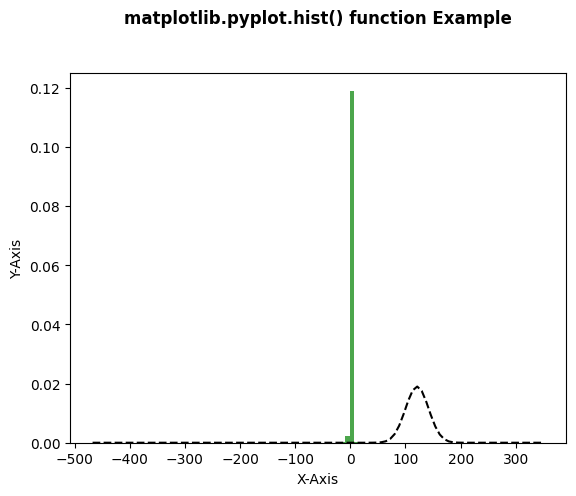

In [24]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
   
np.random.seed(10**7)
mu = 121 
sigma = 21
p_cdf = np.random.rand(10000)
x = 0 + 0.1*np.tan(np.pi*(p_cdf-0.5))
# x = scipy.stats.cauchy.rvs(loc= 0, scale= 0.1,size=10000) 

num_bins = 100
   
n, bins, patches = plt.hist(x, num_bins, 
                            density = 1, 
                            color ='green',
                            alpha = 0.7)
   
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
  
plt.plot(bins, y, '--', color ='black')
  
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
  
plt.title('matplotlib.pyplot.hist() function Example\n\n',
          fontweight ="bold")
  
plt.show()

In [29]:
np.max(r)

5348.916130246166

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


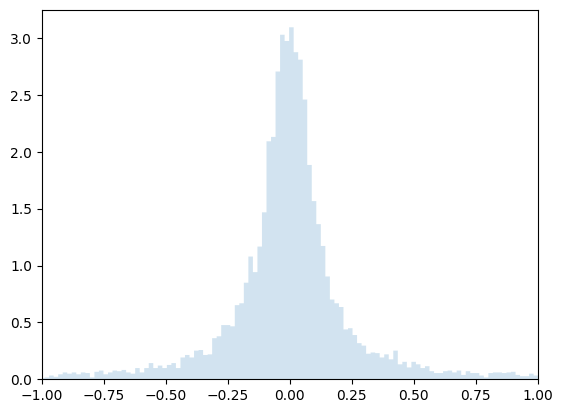

In [68]:
import numpy as np
from scipy.stats import cauchy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
r = scipy.stats.cauchy.rvs(loc= 0, scale= 0.1,size=10000) 
# r = cauchy.rvs(loc= 0, scale=1, size=10000)
# r = np.random.standard_cauchy(size=1000)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([-1, 1])
ax.legend(loc='best', frameon=False)
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


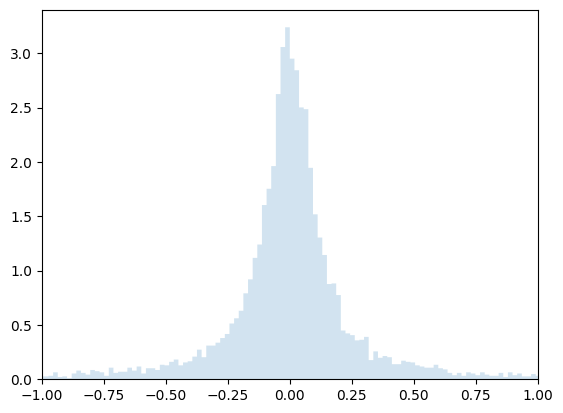

In [69]:
import numpy as np
from scipy.stats import cauchy
import matplotlib.pyplot as plt
from pyMSOO.utils.numba_utils import *
fig, ax = plt.subplots(1, 1)
# r = scipy.stats.cauchy.rvs(loc= 0, scale= 0.1,size=10000) 
# r = cauchy.rvs(size=1000)
r = random_cauchy(0, 0.1)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([-1, 1])
ax.legend(loc='best', frameon=False)
plt.show()  

In [19]:
a = scipy.stats.cauchy.rvs(loc= 0, scale= 0.1,size=1000) 

In [20]:
print(a.shape)

(1000,)


In [25]:
import scipy
for i in range(1000000): 
    # random_gauss(0, 0.1)
    scipy.stats.cauchy.rvs(loc= 0, scale= 0.1) 
    # 0 + 0.1*math.sqrt(-2.0 * math.log(np.random.rand())) * math.sin(2.0 * math.pi * np.random.rand())

AttributeError: module 'scipy' has no attribute 'stats'

In [27]:
smpModel.ls_model[0].ls_model[0].test_time

defaultdict(<function pyMSOO.MFEA.model.LSA21.model.fit.<locals>.<lambda>()>,
            {'time_khoi_tao': 0.036062002182006836,
             'time_khoi_tao_con': 0.18442606925964355,
             'time_random_partner_task': 16.996233224868774,
             'time_random_rmp': 4.32377028465271,
             'time_random_crossover': 5.254285097122192,
             'time_update_delta': 0.3326132297515869,
             'intra_search': 18.581626415252686,
             'intra_search_part2': 135.4548304080963,
             'update_rank': 1.1097030639648438,
             'local_search': 211.33950352668762,
             'time_tao_con_update_quanthe': 407.2332727909088,
             'time_update': 10.490522623062134})

In [ ]:
# scipy.stats.cauchy.rvs(loc= mean, scale= sigma) 

In [13]:
from pyMSOO.utils.numba_utils import *

# random_gauss(0.1,0.1)
random_cauchy(0, 0.1)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'cauchy' of type Module(<module 'scipy.stats' from 'd:\\Application\\Data\\Python\\lib\\site-packages\\scipy\\stats\\__init__.py'>)
[1m
File "pyMSOO\utils\numba_utils.py", line 27:[0m
[1mdef random_gauss(mean, sigma):
    <source elided>
[0m
[0m
[0m[1mDuring: typing of get attribute at d:\Ubuntu\Code\KM-MSO\pyMSOO\pyMSOO\utils\numba_utils.py (27)[0m
[1m
File "pyMSOO\utils\numba_utils.py", line 27:[0m
[1mdef random_gauss(mean, sigma):
    <source elided>
[0m


In [65]:
test = {} 

def xinchao(t):
    t['a']= 0 

xinchao(test)
print(test)

{'a': 0}


In [37]:
from collections import defaultdict
a = defaultdict(lambda: "default")



In [19]:
a['mkaf']

'default'